In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Se criará um dataset a partir da tabela já contendo todos atributos (incluindo clusteres e atributos sintéticos)

In [28]:
atributos = pd.read_excel('Matematica - Atributos Codificados.xlsx', index_col = 0)
atributos.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,absences,G1,G2,RazaoLivreEstudo,RazaoSaidasEstudo,Somatorio,Cluster_estudo,Cluster_familiares,Cluster_sociais,Cluster_geral
0,0,0,18,1,0,0,4,4,0,4,...,6,5,6,1.500000,2.000000,17,0,1,0,0
1,0,0,17,1,0,1,1,1,0,2,...,4,5,5,1.500000,1.500000,12,0,0,0,0
2,0,0,15,1,1,1,1,1,0,2,...,10,7,8,1.500000,1.000000,12,1,0,0,0
3,0,0,15,1,0,1,4,2,1,3,...,2,15,14,0.666667,0.666667,16,0,1,0,0
4,0,0,16,1,0,1,3,3,2,2,...,4,6,10,1.500000,1.000000,16,0,1,0,0


Se utilizará os valores de Informação Mútua (gerados no notebook "Informação mútua e Correlação") para nortear a escolha dos atributos a serem usados nos modelos

In [29]:
informacaoMutua = pd.read_excel('Matematica - Resultados de Informacao Multipla.xlsx', index_col = 0)
#informacaoMutua

Definindo o alvo da análise como sendo a nota na terceira prova de matemática "G3"

In [30]:
alvo = pd.read_csv('student-mat.csv', usecols = ['G3']) 

Criando uma coluna com a informação se o aluno passou ou não, criando-se assim um alvo binário

In [31]:
alvo['Situacao'] = 0
for i in range(len(alvo['G3'])):
    nota = alvo['G3'][i]
    if nota >= 10:
        alvo['Situacao'][i] = 1 # "1" representará o aluno aprovado
    else:
        alvo['Situacao'][i] = 0 # Representará o aluno reprovado

Criando outra coluna com a faixa de nota que o aluno se inclui

In [32]:
alvo['Faixa'] = 0
for i in range(len(alvo['G3'])):
    nota = alvo['G3'][i]
    if nota < 4:
        alvo['Faixa'][i] = 1
    elif nota >= 4 and nota < 8:
        alvo['Faixa'][i] = 2
    elif nota >= 8 and nota < 12:
        alvo['Faixa'][i] = 3
    elif nota >= 12 and nota < 16:
        alvo['Faixa'][i] = 4
    else:
        alvo['Faixa'][i] = 5

Plotando a quantidade a de alunos aprovados/reprovados e em cada faixa de nota

In [33]:
a = pd.DataFrame(alvo[['Faixa','G3']].groupby('Faixa').count())
z = pd.DataFrame(alvo[['Situacao','G3']].groupby('Situacao').count())

Text(0.5, 1.0, 'Alunos em cada faixa de nota')

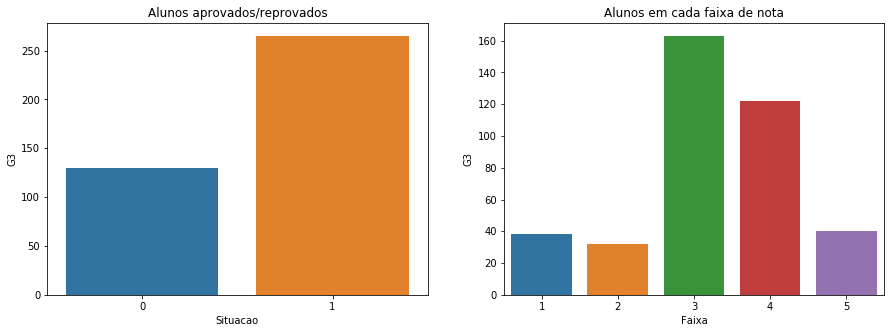

In [34]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
# Alunos aprovados/reprovados
sns.barplot(x =z.index, y =z['G3'], ax = axs[0])
axs[0].set_title('Alunos aprovados/reprovados')
# Alunos em cada faixa de nota
sns.barplot(x =a.index, y =a['G3'], ax = axs[1])
axs[1].set_title('Alunos em cada faixa de nota')

## Construindo modelos de aprendizado de máquina para prever o desempenho em matemática

In [35]:
# Percentual de alunos que passaram
print((alvo[alvo['Situacao']==1]['Situacao'].sum()/len(alvo))*100)

67.08860759493672


Selecionando os atributos.

In [36]:
# Atributos melhor ranqueados em termos de informação mútua,
#porém sem as notas das duas primeiras provas.
X = atributos[informacaoMutua.index.to_list()[2:12]]
# Atributos com as notas das duas primeiras provas
XcomNotas = atributos[informacaoMutua.index.to_list()[:12]]

In [37]:
# Importando os módulos aplicáveis
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


### (1) O primeiro modelo a ser testado será o "Decision Tree

#### (a) Prevendo se o aluno passou ou não

Antes se explorará o efeito de variar seu parâmetro: max_leaf_nodes.

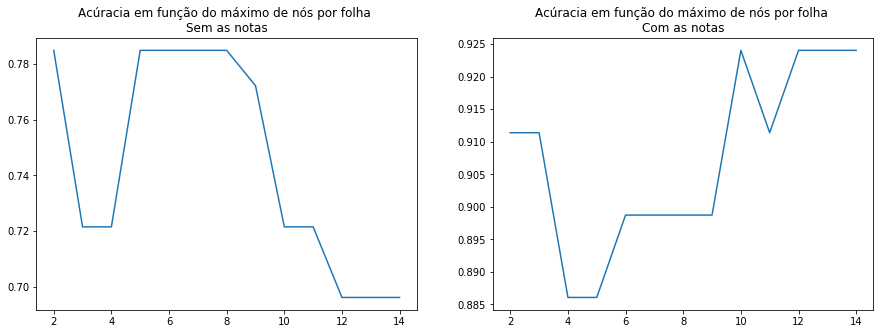

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
atributosTeste = [X, XcomNotas]
labels = ['Sem as notas','Com as notas']
i = 0
for atributo in atributosTeste:
    # Criando subsets para treino e validação do modelo
    treino_X, val_X, treino_notas, val_notas = train_test_split(atributo, alvo['Situacao'], test_size = 0.2, random_state = 1)
    # Será testado o efeito do parâmetro max_leaf_nodes na acurácia do modelo
    acuracias = []
    for nodes in range(2,15):
        # Criando o modelo
        notasArvoreDecisao = DecisionTreeRegressor(max_leaf_nodes=nodes,random_state=0)
        # Treinando o modelo
        notasArvoreDecisao.fit(treino_X, treino_notas)
        # Testando o modelo
        previsoes = notasArvoreDecisao.predict(val_X)
    # Obtendo a acurácia do modelo
        acuracias.append(accuracy_score(val_notas, previsoes.round()))
    # Plotando os resultados
    pd.Series(data = acuracias, index = [i for i in range(2,15)]).plot(kind = 'line', ax = axs[i])
    axs[i].set_title('Acúracia em função do máximo de nós por folha \n' + labels[i])
    i = i + 1

Explorando o efeito do parâmetro "min_samples_leaf" utilizando o melhor valor de "max_leaf_nodes" para cada conjunto de atributos

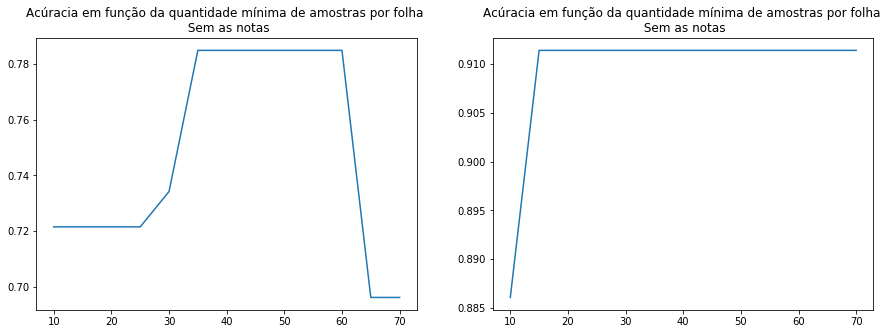

In [39]:
from random import seed
from statistics import mean
from random import randint
seed(1)
# Modelo sem as notas primeira e segunda prova
treino_X, val_X, treino_notas, val_notas = train_test_split(X, alvo['Situacao'], test_size = 0.2, random_state = randint(0,5))
# Será testado o efeito do parâmetro "min_samples_leaf" na acurácia do modelo
acuracias = []
for leafs in range(2,15):
    # Criando o modelo
    notasArvoreDecisao = DecisionTreeRegressor(max_leaf_nodes=5,min_samples_leaf = leafs*5,random_state=randint(0,5))
    # Treinando o modelo
    notasArvoreDecisao.fit(treino_X, treino_notas)
    # Testando o modelo
    previsoes = notasArvoreDecisao.predict(val_X)
    # Obtendo a acurácia do modelo
    acuracias.append(accuracy_score(val_notas, previsoes.round()))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))    
pd.Series(data = acuracias, index = [i*5 for i in range(2,15)]).plot(kind = 'line', ax = axs[0])
axs[0].set_title('Acúracia em função da quantidade mínima de amostras por folha \n Sem as notas')

# Modelo com as notas primeira e segunda prova
treino_X, val_X, treino_notas, val_notas = train_test_split(XcomNotas, alvo['Situacao'], test_size = 0.2, random_state = 1)
# Será testado o efeito do parâmetro "min_samples_leaf" na acurácia do modelo
acuracias = []
for leafs in range(2,15):
    # Criando o modelo
    notasArvoreDecisao = DecisionTreeRegressor(max_leaf_nodes= 9,min_samples_leaf = leafs*5,random_state=1)
    # Treinando o modelo
    notasArvoreDecisao.fit(treino_X, treino_notas)
    # Testando o modelo
    previsoes = notasArvoreDecisao.predict(val_X)
    # Obtendo a acurácia do modelo
    acuracias.append(accuracy_score(val_notas, previsoes.round()))

pd.Series(data = acuracias, index = [i*5 for i in range(2,15)]).plot(kind = 'line', ax = axs[1])
axs[1].set_title('Acúracia em função da quantidade mínima de amostras por folha \n Sem as notas')
plt.show()


Abaixo se utilizará a melhor combinação dos hiperparâmetros ("max_leaf_nodes" e "min_samples_leaf") para construir e comprar modelos com cada conjunto de atributos: (1) atributos bem ranqueados em termo de informação mútua sem as notas da primeira e segunda prova e (2) atributos bem ranqueados mais as notas dessas provas

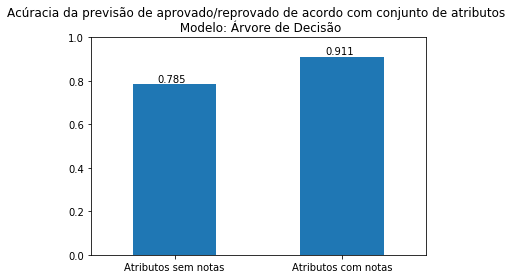

In [57]:
# Sintetizando a diferença entre os dois conjuntos de atributos
    # Atributos sem as notas
treino_X, val_X, treino_notas, val_notas = train_test_split(X, alvo['Situacao'], test_size = 0.2, random_state = randint(0,5))
# Criando o modelo
notasArvoreDecisao = DecisionTreeRegressor(max_leaf_nodes=5,min_samples_leaf = 50,random_state=randint(0,5))
# Treinando o modelo
notasArvoreDecisao.fit(treino_X, treino_notas)
# Testando o modelo
previsoesSemNotas = notasArvoreDecisao.predict(val_X)
# Obtendo a acurácia do modelo
acuraciaSemNotas = accuracy_score(val_notas, previsoesSemNotas.round())

    # Atributos com as notas
treino_X, val_X, treino_notas, val_notas = train_test_split(XcomNotas, alvo['Situacao'], test_size = 0.2, random_state = 1)
# Criando o modelo
notasArvoreDecisao1 = DecisionTreeRegressor(max_leaf_nodes=9,min_samples_leaf = 20,random_state=1)
# Treinando o modelo
notasArvoreDecisao1.fit(treino_X, treino_notas)
# Testando o modelo
previsoesComNotas = notasArvoreDecisao1.predict(val_X)
# Obtendo a acurácia do modelo
acuraciaComNotas = accuracy_score(val_notas, previsoesComNotas.round())

fig, axs = plt.subplots()
# Plotando os resultados de acuracia
pd.Series(data = [acuraciaSemNotas,acuraciaComNotas],
          index = ['Atributos sem notas','Atributos com notas']).plot(kind = 'bar', ax = axs)
axs.set_title('Acúracia da previsão de aprovado/reprovado de acordo com conjunto de atributos \n Modelo: Árvore de Decisão')
axs.set_ylim(0,1)
axs.text(-0.1,acuraciaSemNotas +0.01, str(round(acuraciaSemNotas,3)))
axs.text(0.9, acuraciaComNotas + 0.01, str(round(acuraciaComNotas,3)))
axs.set_xticklabels(labels = ['Atributos sem notas','Atributos com notas'], rotation = 0)
plt.show()


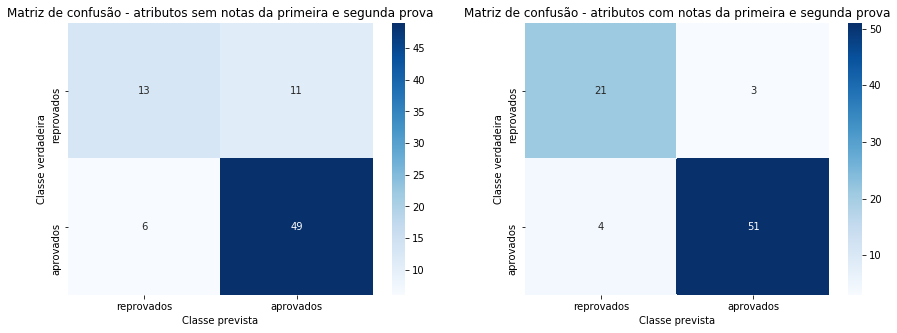

Atributos sem notas da primeira e segunda provas 
               precision    recall  f1-score   support

           0       0.68      0.54      0.60        24
           1       0.82      0.89      0.85        55

    accuracy                           0.78        79
   macro avg       0.75      0.72      0.73        79
weighted avg       0.78      0.78      0.78        79

Atributos com notas da primeira e segunda provas 
               precision    recall  f1-score   support

           0       0.84      0.88      0.86        24
           1       0.94      0.93      0.94        55

    accuracy                           0.91        79
   macro avg       0.89      0.90      0.90        79
weighted avg       0.91      0.91      0.91        79



In [58]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Plotando matriz de confusão dos atributos sem as notas
cmSemNotas = confusion_matrix(val_notas, previsoesSemNotas.round())
sns.heatmap(cmSemNotas, annot=True, fmt='g', ax=axs[0], cmap='Blues')
axs[0].set_xlabel('Classe prevista');axs[0].set_ylabel('Classe verdadeira')
axs[0].set_title('Matriz de confusão - atributos sem notas da primeira e segunda prova')
axs[0].xaxis.set_ticklabels(['reprovados', 'aprovados'])
axs[0].yaxis.set_ticklabels(['reprovados', 'aprovados'])

# Plotando matriz de confusão dos atributos com as notas
cmComNotas = confusion_matrix(val_notas, previsoesComNotas.round())
sns.heatmap(cmComNotas, annot=True, fmt='g', ax=axs[1], cmap='Blues')
axs[1].set_xlabel('Classe prevista');axs[1].set_ylabel('Classe verdadeira')
axs[1].set_title('Matriz de confusão - atributos com notas da primeira e segunda prova')
axs[1].xaxis.set_ticklabels(['reprovados', 'aprovados'])
axs[1].yaxis.set_ticklabels(['reprovados', 'aprovados'])

plt.show()

# Imprimindo relatório dos resultados
print('Atributos sem notas da primeira e segunda provas \n',
     classification_report(val_notas, previsoesSemNotas.round()))
print('Atributos com notas da primeira e segunda provas \n',
     classification_report(val_notas, previsoesComNotas.round()))

In [55]:
# Sintetizando a diferença entre os dois conjuntos de atributos
    # Atributos sem as notas
from random import seed
from statistics import mean
from random import randint
seed(1)
acuracia = []
for i in range(500):
    treino_X, val_X, treino_notas, val_notas = train_test_split(X, alvo['Situacao'], test_size = 0.2, random_state = randint(0,5))
    # Criando o modelo
    notasArvoreDecisao = DecisionTreeRegressor(max_leaf_nodes=5,min_samples_leaf = 50,random_state=randint(0,7))
    # Treinando o modelo
    notasArvoreDecisao.fit(treino_X, treino_notas)
    # Testando o modelo
    previsoesSemNotas = notasArvoreDecisao.predict(val_X)
    # Obtendo a acurácia do modelo
    acuracia.append(accuracy_score(val_notas, previsoesSemNotas.round()))
mean(acuracia)

0.7351392405063292

#### (b) Prevendo a nota atingida pelo aluno

Obs: Desta vez se utilizará como métrica de desempenho do modelo o erro médio absoluto

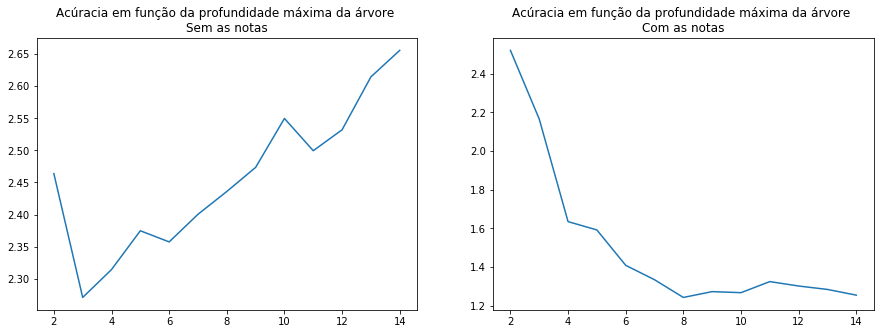

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
atributosTeste = [X, XcomNotas]
labels = ['Sem as notas','Com as notas']
i = 0
for atributo in atributosTeste:
    # Criando subsets para treino e validação do modelo
    treino_X, val_X, treino_notas, val_notas = train_test_split(atributo, alvo['G3'], test_size = 0.2, random_state = 1)
    # Será testado o efeito do parâmetro max_leaf_nodes na acurácia do modelo
    acuracias = []
    for nodes in range(2,15):
        # Criando o modelo
        notasArvoreDecisao = DecisionTreeRegressor(max_leaf_nodes=nodes,random_state=1)
        # Treinando o modelo
        notasArvoreDecisao.fit(treino_X, treino_notas)
        # Testando o modelo
        previsoes = notasArvoreDecisao.predict(val_X)
    # Obtendo a acurácia do modelo
        acuracias.append(mean_absolute_error(val_notas, previsoes))
    # Plotando os resultados
    pd.Series(data = acuracias, index = [i for i in range(2,15)]).plot(kind = 'line', ax = axs[i])
    axs[i].set_title('Acúracia em função da profundidade máxima da árvore \n' + labels[i])
    i = i + 1

Text(0.5, 1.0, 'Acúracia em função da quantidade mínima de amostras por folha \n Sem as notas')

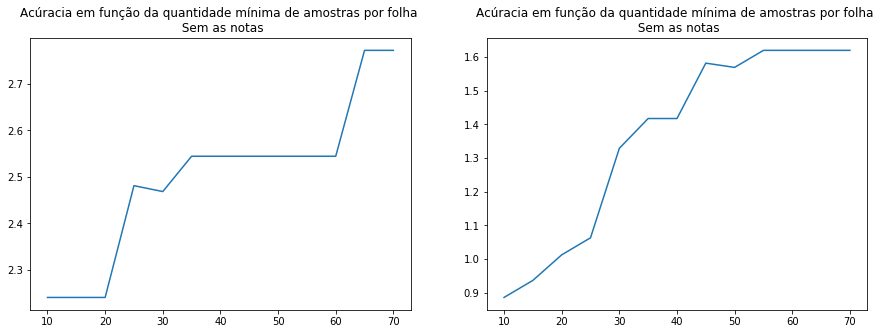

In [44]:
# Modelo sem as notas primeira e segunda prova
treino_X, val_X, treino_notas, val_notas = train_test_split(X, alvo['G3'], test_size = 0.2, random_state = 1)
# Será testado o efeito do parâmetro "min_samples_leaf" na acurácia do modelo
acuracias = []
for leafs in range(2,15):
    # Criando o modelo
    notasArvoreDecisao = DecisionTreeRegressor(max_leaf_nodes=3,min_samples_leaf = leafs*5,random_state=1)
    # Treinando o modelo
    notasArvoreDecisao.fit(treino_X, treino_notas)
    # Testando o modelo
    previsoes = notasArvoreDecisao.predict(val_X)
    # Obtendo a acurácia do modelo
    acuracias.append(mean_absolute_error(val_notas, previsoes.round()))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))    
pd.Series(data = acuracias, index = [i*5 for i in range(2,15)]).plot(kind = 'line', ax = axs[0])
axs[0].set_title('Acúracia em função da quantidade mínima de amostras por folha \n Sem as notas')

# Modelo com as notas primeira e segunda prova
treino_X, val_X, treino_notas, val_notas = train_test_split(XcomNotas, alvo['G3'], test_size = 0.2, random_state = 1)
# Será testado o efeito do parâmetro "min_samples_leaf" na acurácia do modelo
acuracias = []
for leafs in range(2,15):
    # Criando o modelo
    notasArvoreDecisao = DecisionTreeRegressor(max_leaf_nodes= 14,min_samples_leaf = leafs*5,random_state=1)
    # Treinando o modelo
    notasArvoreDecisao.fit(treino_X, treino_notas)
    # Testando o modelo
    previsoes = notasArvoreDecisao.predict(val_X)
    # Obtendo a acurácia do modelo
    acuracias.append(mean_absolute_error(val_notas, previsoes.round()))

pd.Series(data = acuracias, index = [i*5 for i in range(2,15)]).plot(kind = 'line', ax = axs[1])
axs[1].set_title('Acúracia em função da quantidade mínima de amostras por folha \n Sem as notas')


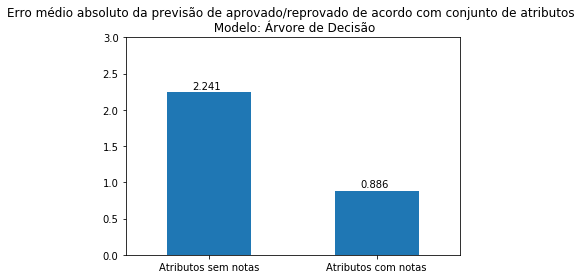

In [45]:
# Sintetizando a diferença entre os dois conjuntos de atributos
    # Atributos sem as notas
treino_X, val_X, treino_notas, val_notas = train_test_split(X, alvo['G3'], test_size = 0.2, random_state = 1)
# Criando o modelo
notasArvoreDecisao = DecisionTreeRegressor(max_leaf_nodes=3,min_samples_leaf = 10,random_state=1)
# Treinando o modelo
notasArvoreDecisao.fit(treino_X, treino_notas)
# Testando o modelo
previsoes = notasArvoreDecisao.predict(val_X)
# Obtendo a acurácia do modelo
acuraciaSemNotas = mean_absolute_error(val_notas, previsoes.round())

    # Atributos com as notas
treino_X, val_X, treino_notas, val_notas = train_test_split(XcomNotas, alvo['G3'], test_size = 0.2, random_state = 1)
# Criando o modelo
notasArvoreDecisao = DecisionTreeRegressor(max_leaf_nodes=14,min_samples_leaf = 10,random_state=1)
# Treinando o modelo
notasArvoreDecisao.fit(treino_X, treino_notas)
# Testando o modelo
previsoes = notasArvoreDecisao.predict(val_X)
# Obtendo a acurácia do modelo
acuraciaComNotas = mean_absolute_error(val_notas, previsoes.round())

fig, ax = plt.subplots()
pd.Series(data = [acuraciaSemNotas,acuraciaComNotas],
          index = ['Atributos sem notas','Atributos com notas']).plot(kind = 'bar')
plt.title('Erro médio absoluto da previsão de aprovado/reprovado de acordo com conjunto de atributos \n Modelo: Árvore de Decisão')
ax.set_ylim(0,3)
ax.text(-0.1,acuraciaSemNotas +0.05, str(round(acuraciaSemNotas,3)))
ax.text(0.9, acuraciaComNotas + 0.05, str(round(acuraciaComNotas,3)))
ax.set_xticklabels(labels = ['Atributos sem notas','Atributos com notas'], rotation = 0)
plt.show()